# **Statistical Rethinking: A Bayesian course with examples in Python**
# **Ch 3 - Sampling the Imaginary**

**Note**

- A key difference between Frequentist Statistical Inference and Bayesian Statistical Inference is:

  - Frequentist Inference is concerned with the data (hypothetical / data that they don't have yet) itself and procedural replicability. They're trying to accurately model how the broader population would look with the sample that they have. More fixed. Top-down in terms of data-producing scenarios.
  - Bayesian Inference, on the other hand, is concerned with the data THEY DO HAVE, and they're primarily concerned with counting all the ways that the particular conjecture of data they have to work with could have been generated. This perspective is more comfortable with producing multiple scenarios producting the data which is takes the opposite approach of Frequentist inference in being bottom-up.

## Intro 

Recap on the important features of Bayesian inference:
- **Data**: The particular conjecture of outcomes that are presented to us.
- **Likelihood**: The probability/likelihood of that particular conjecture of data, often represented as the **probability of the evidence** $P(E | H)$ in Bayes' Theorem. For example, the probability of observing 6 W's in 9 Tosses in the globe tossing experiment.
- **Parameters**: The value we want to estimate, often representing the **prior** $P(H)$ in Bayes' Theorem. For example, going back to the Globe Tossing Experiment, we initialized our model with a 50/50 chance of the globe landing in either water or land. However, as we increase our sample size (let's say 1000 tosses), our model updates towards a parameter that more accurately represents the true ratio between water-to-land, which is roughly $0.71$ (i.e. our index finger will land on water in approximately 710 of those tosses).
- **Marginal/Average Likelihood** $P(E)$: See below.
- **Posterior**: This value is what we're trying to estimate for and represents the output of our model's learning process, which then becomes the *prior* in the next iteration.  

Let's review Bayes' Theorem by using one of the most common examples of its application to medical testing from books introducing the concept. Below are the following *constants* in the hypothetical medical testing example that's often used in textbooks to illustrate Bayes' Theorem, <u>GIVEN</u> that the data has a **Binomial Distribution** (meaning there are only two possible outcomes):

- The probability that the medical test can correctly identify someone with a given virus (i.e. the **statistical power** of the test): $P(Test^+ | Virus^+) = 0.95$
- The amount of people in the population that actually carry the virus: $P(Virus^+) = 0.001 $
- The probability of a false positive, which in other words, is the probability that the test diagnoses someone as being a virus carrier even though they are not: $P(Test^+ | Virus^-) = 0.01  $ 

Now that we've received some information about the medical test, the question we want to answer is: *What is the probability that a person who carries the virus will actually test positive for it on the first attempt?*

**Bayes Theorem**: 

$ P(H | E) = \frac{P(H) \times P(E | H)}{P(E)} $

<br>

**Bayes Theorem** *given* the probability of the data/evidence is <u>UNKNOWN</u> and the data has a <u>**binomial distribution**</u>: 

$ P(H | E) = \frac{P(H) \times P(E | H)}{(P(H) \cdot P(E | H)) + (P(H^-) \cdot P(E | H^-))} $

<br> 

Bayes Theorem Applied using the version where the probability of the data/evidence is *UNKNOWN* with a *BINOMIAL DISTRIBUTION*: 

$P(Virus^+ | Test^+) = \frac{P(Virus^+) \times P(Test^+ | Virus^+)}{(P(Virus^+) \cdot P(Test^+ | Virus^+)) + (P(Virus^-) \cdot P(Test^+ | Virus^-))} $

$P(Virus^+ | Test^+) = \frac{0.001 \times 0.95}{(0.001 \cdot 0.95) + (0.999 \cdot 0.01)} $

$P(Virus^+ | Test^+) =  \frac{0.00095}{0.0000094905}$

$P(Virus^+ | Test^+) =  0.08683729433272395 ≈ 0.087$  

In [ ]:
# Constants
likelihood = 0.95
prior = 0.001
false_pos = 0.01

# Applying Bayes Theorem:

posterior1 = (prior * likelihood) / ((prior * likelihood) + ((1-prior) * false_pos))
print(f"Numerator: {prior * likelihood}")
print(f"Denominator: {(prior * likelihood) * ((1-prior) * false_pos)}")
print(f"The new Posterior Probability: {posterior1}")

Numerator: 0.00095
Denominator: 9.4905e-06
The new Posterior Probability: 0.08683729433272395


Although our medical test is 95% accurate in detecting scenarios where a person carrying the virus tests positive (i.e. $P(Virus^+ | Test^+)$), we need to consider the other variables associated with the medical test. For example, we need to consider the prevalence of the virus (i.e. $P(Virus^+)$), which is our **prior probability**. Then, to gain a larger, more accurate view of the medical test, we need to evaluate the likelihood that a person is carrying the virus *given* that they've tested positive on the test (i.e. $P(Virus^+ | Test^+)$). In this case, $P(Virus^+ | Test^+)$ is still relatively low with an 8.7% chance of occurring because our prior was *VERY LOW* to begin with. 

If we want to increase the accuracy of our results, one solution is to test a person more than once and update the prior after each test. In this second round of testing, our new prior will be $P(Virus^+ | Test^+) = 0.087$ to reflect the posterior from our first test.

In [ ]:
posterior2 = (posterior1 * likelihood) / ((posterior1 * likelihood) + ((1- posterior1) * false_pos))

print(f"Numerator: {posterior1 * likelihood}")
print(f"Denominator: {(posterior1 * likelihood) * ((1 - posterior1) * false_pos)}")
print(f"The new Posterior Probability: {posterior2}")

Numerator: 0.08249542961608776
Denominator: 0.0007533174971341104
The new Posterior Probability: 0.900339185953711


As we can see from our application of Bayes Theorem, re-testing our patients results in a higher probability that they actually carry the virus from testing positive twice in a row. In other words, if a person were to test positive for a virus twice in a row, there's about a 90% chance they are indeed infected. 

In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import scipy.stats as stats

In [ ]:
%config InlineBackend.figure_format = 'retina'
# %load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

### Why this generic example of Bayes Theorem sucks.

Despite the common usage of medical testing as an example to illustrate how Bayes' Theorem works in practice, it can be challenging to grasp because of how the constants are reported as probabilities/percentages. There's nothing uniquely "Bayesian" about this example. The reason being is that **Bayesian Inference is distinguished by a broad use of probability, <u>NOT</u> the use of Bayes' Theorem.** 

Since all of the probabilities provided above reference frequencies of events rather than theoretical parameters, all major statistical philosophies would agree to use Bayes' Theorem in this case.

Additionally, it's harder for people to remember where each number/constant goes in the equation, which makes Bayesian inference seem harder than it has to be. To simplify things, let's reframe the problem in another context where we use counts/frequencies of events rather than their proportions:

1. In a population of 100,000 people, 100 of them were vampires;
2. Of the 100 people who are vampires, 95 of them will test positive for a vampire detection test;
3. Of the 99,900 mortals, 999 of them will ALSO test positive in the vampire detection test.

Now, if we were to ask the question: Of the people who test positive, what percentage of them are actually vampires? The answer to this requires us to add the vampires who tested positive (i.e. the True Positives $TP = 95$) with the normal people who also tested positive (i.e. the False Positives $FP = 999$) to get the total number of people who was identified as positive (i.e. Predicted Positive = $999 + 95 = 1094$). Now, if we divide the True Positives by total people who were Predicted Positive, that will represent the test's accuracy for correctly identifying vampires when tested only once: 

#### Code 3.1

$Pr(vampire|positive) = \frac{Pr(positive|vampire) Pr(vampire)} {Pr(positive)}$

$Pr(positive) = Pr(positive|vampire) Pr(vampire) + Pr(positive|mortal) (1 − Pr(vampire))$

$ Pr(vampire | positive) = \frac{Pr(positive | vampire) \cdot Pr(vampire)}{Pr(positive)} = \frac{95}{(999 + 95)} = 0.087 $

In [ ]:
# Using proprortions
PrPV = 0.95
PrPM = 0.01
PrV = 0.001
PrP = PrPV * PrV + PrPM * (1 - PrV)
PrVP = PrPV * PrV / PrP
PrVP

0.08683729433272395

In [ ]:
# Using frequencies
population = 100000
vampires = 100

vamp_pos = 95/vampires
true_vamps_prior = vampires/population
pos_mortals = 999 / (population - vampires) # 999 / 990000

unstd_posterior = true_vamps_prior * vamp_pos #Num
avg_likelihood = unstd_posterior + (pos_mortals * (1 - true_vamps_prior)) #Denom

posterior = unstd_posterior / avg_likelihood
posterior

0.08683729433272395

Our resulting answer is exactly the same as our previous example, $P(Virus^+ | Test^+) = 0.087$, only without the probabilies. To most people, the second example of *using counts instead of frequencies* is more intuitive because **natural frequencies** (also called the **frequency format**) are things we encounter in everyday life. We don't often encounter probabilities in the natural world. 

In this chapter, we'll follow a similar pattern of reframing by sampling **probability distributions** to produce counts which are a little more intuitive for people to understand. Posterior Distributions are Probability Distributions which means we can sample from them to produce *parameter values* from those sampled events. From a Bayesian perspective, parameter values are relative plausibilities, not physically random processes.

Therefore, posteriors define the *expected frequency* of different parameter values appearing once we start plucking out parameters from the posterior. All this will make sense as we move along in the chapter. 

## *Section 3.1* - Sampling from a grid-approximate posterior



#### Code 3.2 - 3.5

We are going to use the same function we use on chapter 2 (code 2.3)

In [ ]:
def uniform_prior(grid_points):
    """
    Returns Uniform (i.e. a flat) prior density (i.e. returns the number 5 in this case, x number of times)

            Parameters:
                grid_points (numpy.array): Array of prior values

            Returns:
                density (numpy.array): Uniform density of prior values
    """
    return np.repeat(5, grid_points)  


def truncated_prior(grid_points, trunc_point=0.5):
    """
    Returns Truncated prior density

            Parameters:
                grid_points (numpy.array): Array of prior values
                trunc_point (double): Value where the prior is truncated

            Returns:
                density (numpy.array): Truncated density of prior values
    """
    return (np.linspace(0, 1, grid_points) >= trunc_point).astype(int)


def double_exp_prior(grid_points):
    """
    Returns Double Exponential prior density

            Parameters:
                grid_points (numpy.array): Array of prior values

            Returns:
                density (numpy.array): Double Exponential density of prior values
    """
    return np.exp(-5 * abs(np.linspace(0, 1, grid_points) - 0.5))

In [ ]:
def binom_post_grid_approx(prior_func, grid_points=5, success=6, tosses=9):
    """
    Returns the grid approximation of posterior distribution with a binomial likelihood.

            Parameters:
                    prior_func (function): A function that returns the likelihood of the prior
                    grid_points (int): Number of points in the prior grid
                    successes (int): Number of successes
                    tosses (int): number of tosses

            Returns:
                    p_grid (numpy.array): Array of prior values
                    posterior (numpy.array): Likelihood (density) of prior values
    """
    # define grid
    p_grid = np.linspace(0, 1, grid_points)

    # define prior
    prior = prior_func(grid_points)

    # compute likelihood at each point in the grid
    likelihood = stats.binom.pmf(success, tosses, p_grid)

    # compute product of likelihood and prior
    unstd_posterior = likelihood * prior

    # standardize the posterior, so it sums to 1
    posterior = unstd_posterior / unstd_posterior.sum()
    
    return p_grid, posterior

In [ ]:
p_grid, posterior = binom_post_grid_approx(uniform_prior, grid_points=100, success=6, tosses=9)

samples = np.random.choice(p_grid, p=posterior, size=int(1e4), replace=True)

### PyMC Review on **Binomial Posterior Grid Approximation**:

The `binom_post_grid_approx` function uses the "`uniform_prior`" function to return the number 5 $x$-number of times (in this case, we're returning it 100 times). The `p_grid` function returns 100 even inputs between 0 and 1 to serve as the prior to illustrate how the posterior probability of achieving the particular conjecture of data changes (6 Ws out 9 tosses) based on what our priors are. So, for example, each prior fed into our grid-approximate posterior is $x = [0.01, 0.02, 0.03...]$. Therefore, the function will return both the priors from `p_grid` AND the posterior distribution of sampling that particular conjecture of data.

Once we've generated a list of posteriors from the uniform priors, we'll create a `samples` array from the `np.random.choice` function, which samples 1000 values (`size` argument) from the priors array (`a` argument) given each of the probabilities listed in the posterior (`p` arg).


p_grid (priors): [0.60606061 0.61616162 0.62626263 0.63636364 0.64646465 0.65656566
 0.66666667 0.67676768 0.68686869 0.6969697  0.70707071] 

 posterior probability of the data: [0.02570565 0.02625773 0.02672284 0.02709431 0.027366   0.02753241
 0.0275888  0.02753126 0.02735684 0.0270636  0.02665076] 

 1000 Samples from the p_grid array, with the probability of each sample coming from each posterior value in the post array: 
 [0.66666667 0.66666667 0.63636364 0.58585859 0.38383838 0.45454545
 0.65656566 0.72727273 0.53535354 0.64646465 0.41414141] 


Text(0.5, 1.0, 'Grid Approximation Distribution')

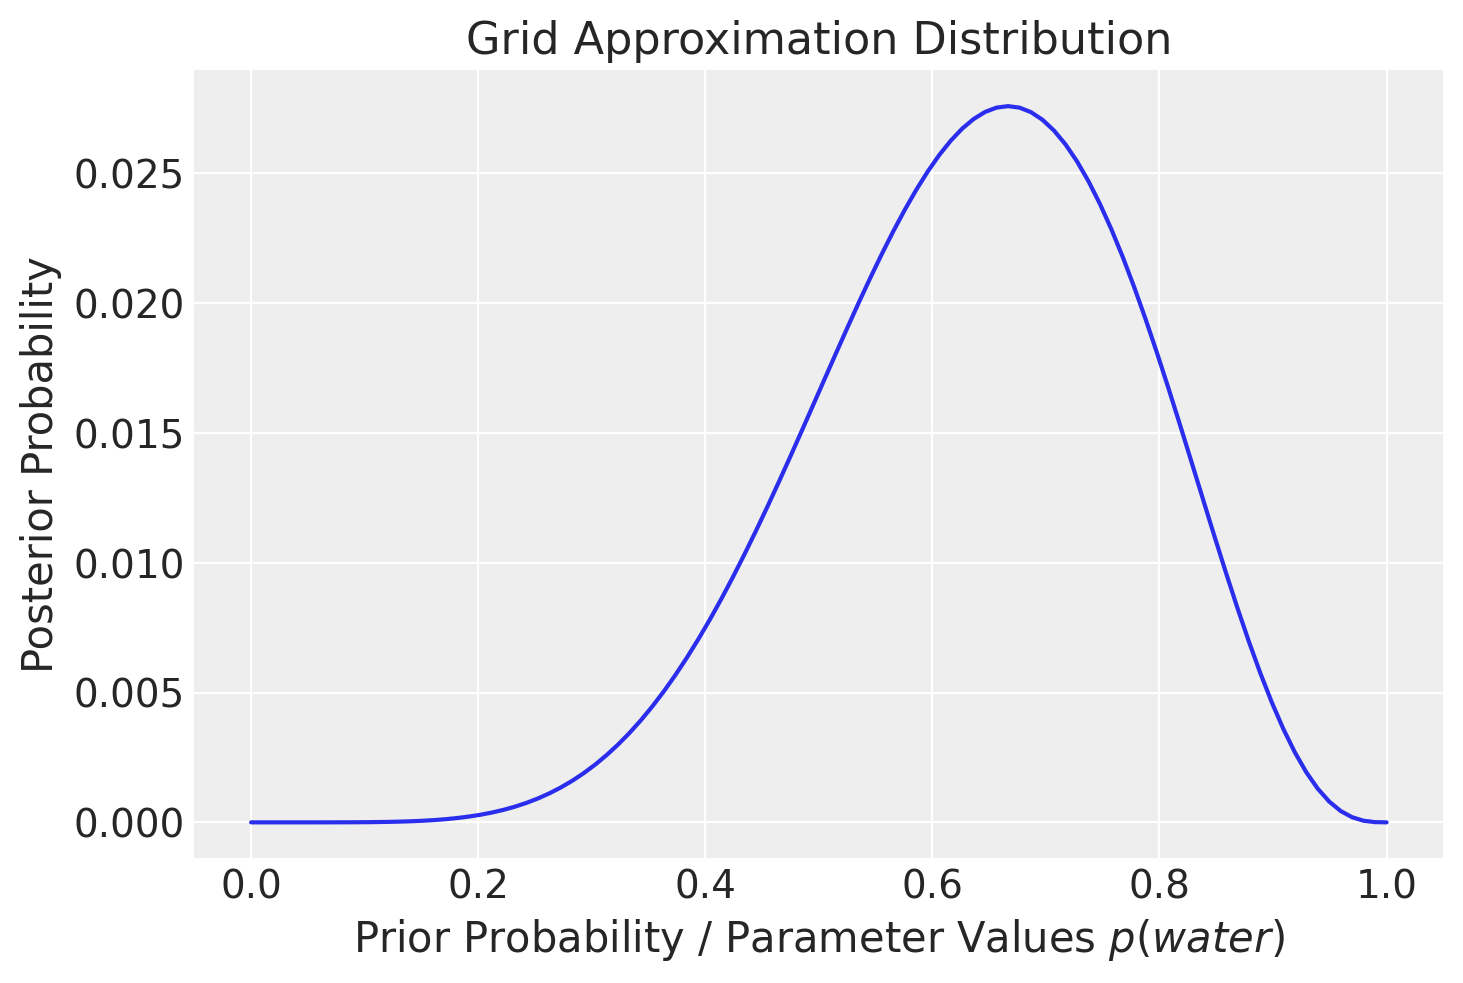

In [ ]:
print(f"p_grid (priors): {p_grid[60:71]} \n\n \
posterior probability of the data: {posterior[60:71]} \n\n \
1000 Samples from the p_grid array, with the probability of each sample coming from each posterior value in the post array: \n {samples[60:71]} ")

plt.plot(p_grid, posterior)
plt.ylabel("Posterior Probability")
plt.xlabel("Prior Probability / Parameter Values $p(water)$")
plt.title(f"Grid Approximation Distribution")

And in the graph below, we'll plot the density (i.e. the number of times that the particular posterior probability got sampled) of the samples to find that values around 0.61 were sampled the most from our `np.random.choice` function. This distribution mostly reflects the **Grid Approximate Distribution** graph generated in the previous code cell.

## *Section 3.2* - Sampling to summarize

With our model's help in generating a posterior distribution, our job in summarizing and interpreting the posterior distribution has just begun. A few questions you could ask about your data include: 
- How much of the posterior probability lies below some parameter value? This is a question about intervals of *defined boundaries*.
- How much of the posterior distribution lies between two parameter values? So is this.
- Which parameter value marks the lower 5% of the posterior probability? This is a question about intervals of *defined probability mass*.
- Which range of parameter values contain 90% of the posterior probability? So is this.
- Which parameter value has the highest posterior probability? This last question is a question about *point estimates*.

Text(0, 0.5, 'density')

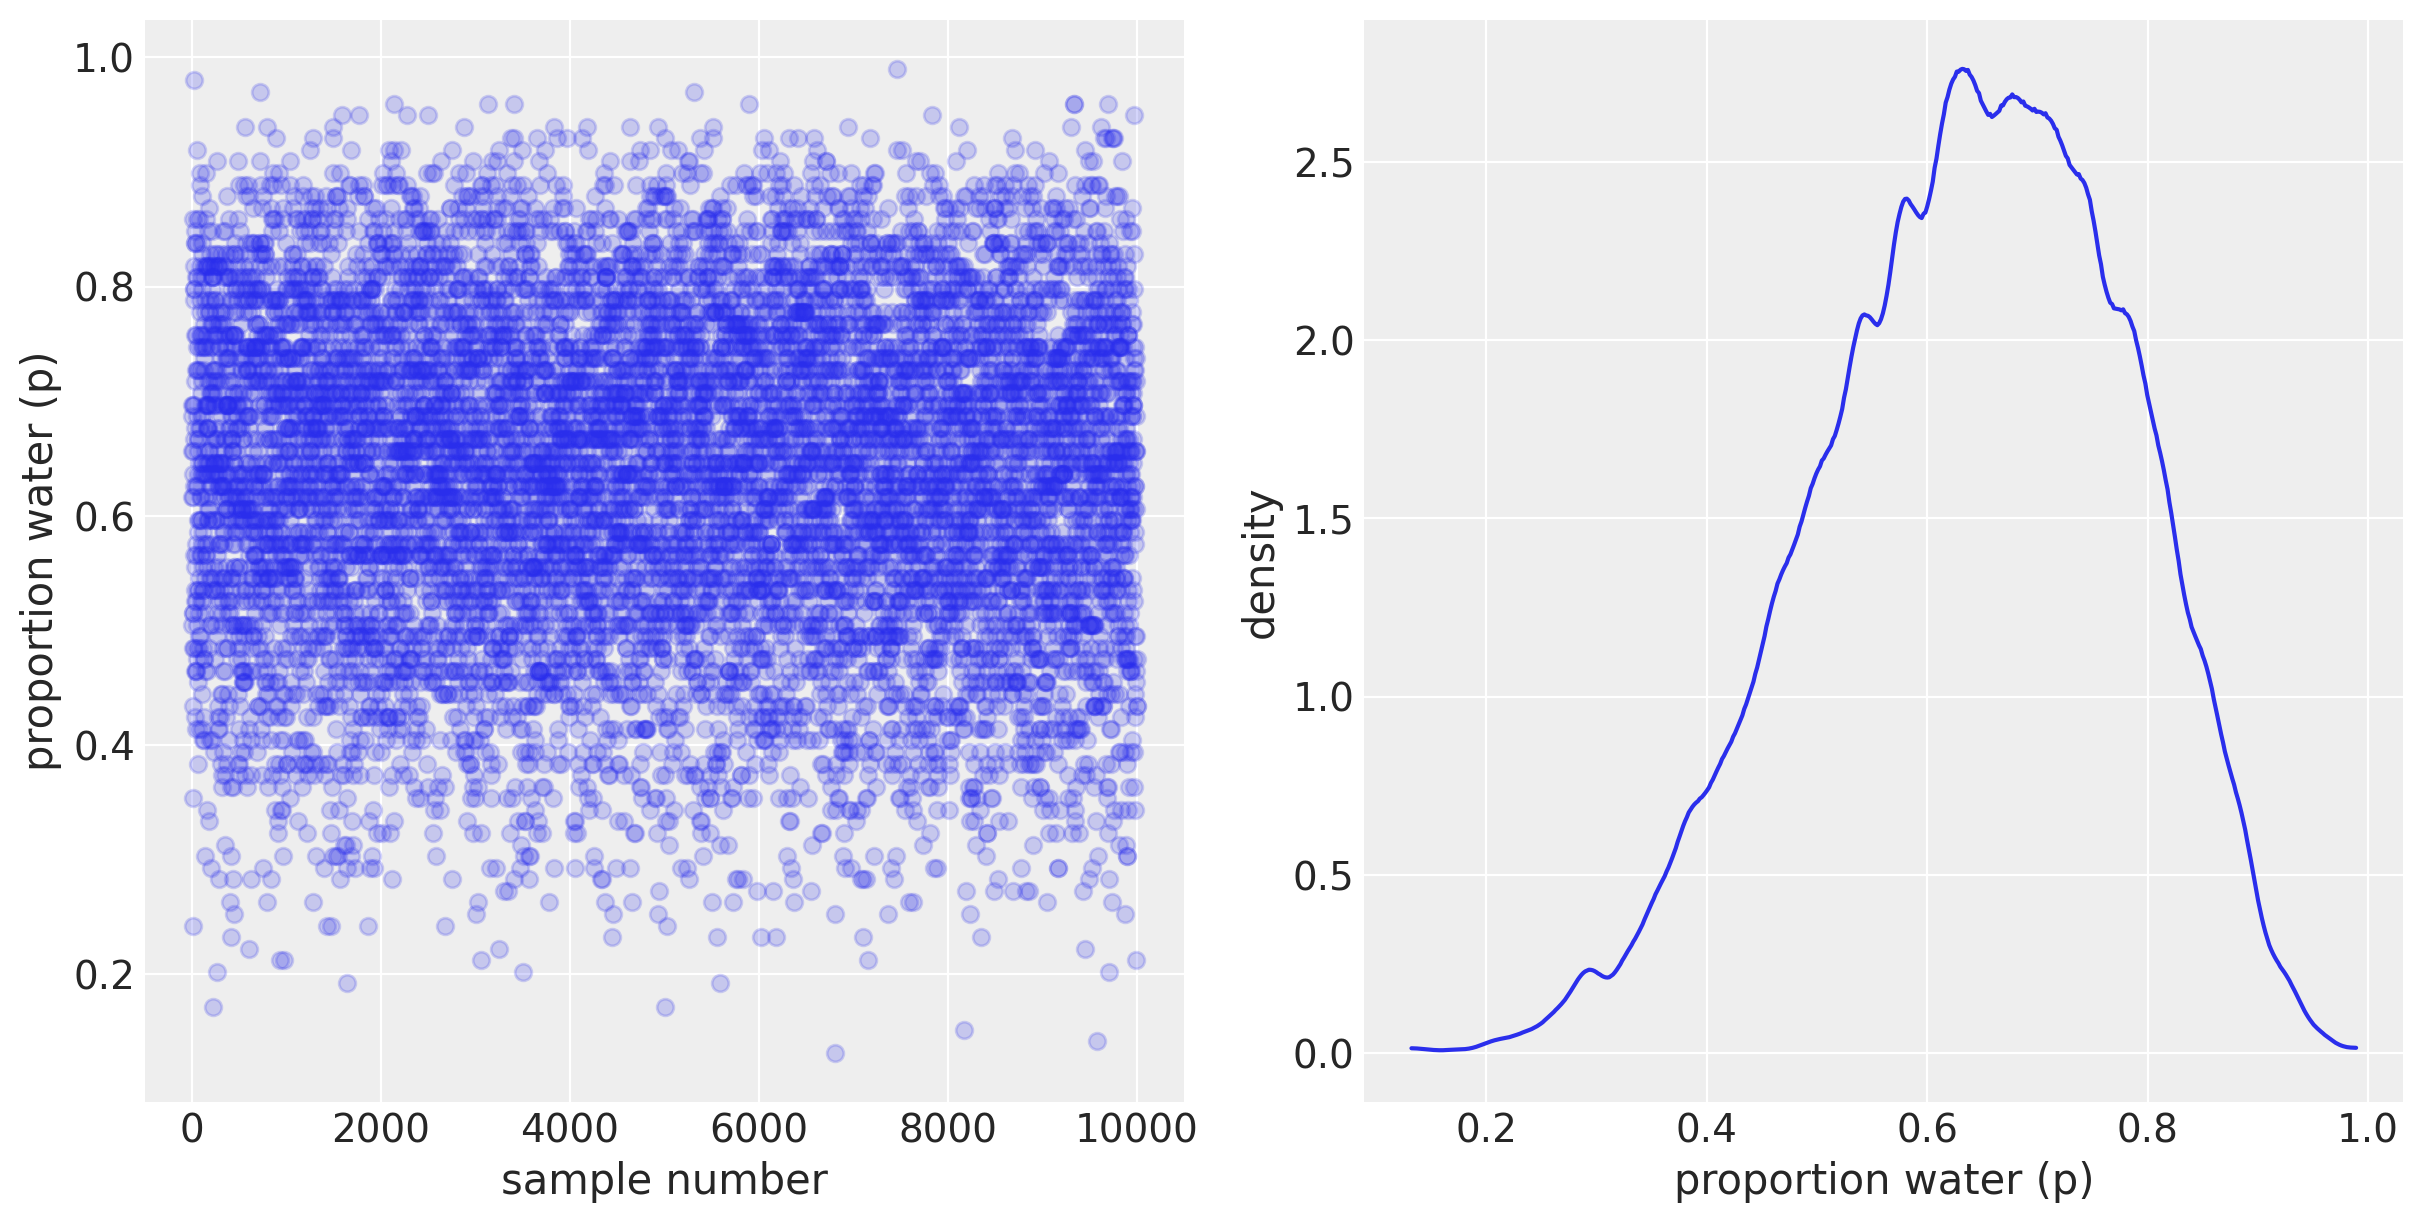

In [ ]:
_, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6))
ax0.plot(samples, "o", alpha=0.2)
ax0.set_xlabel("sample number")
ax0.set_ylabel("proportion water (p)")
az.plot_kde(samples, ax=ax1)
ax1.set_xlabel("proportion water (p)")
ax1.set_ylabel("density")

#### Code 3.6

### 3.2.1 **Intervals of defined boundaries.** 

If you wanted to know what was the posterior probability that the proportion of water on Earth is less than 0.5 using the *grid-approximate posterior*, you could find that out by adding up all the posterior probabilities of parameters/priors that are less than 0.5 which we'll find to be about 17%.

Once we move beyond situations where Grid Approximation isn't as practical, such as when we have more than one parameter in the posterior distribution, this calculation won't be as simple.

In [ ]:
sum(posterior[p_grid < 0.5])

0.17183313110747475

#### Code 3.7

Similarly, if we were to add up all the posterior probabilities that we *sampled* which were less than $p = 0.5$, we'll find a comparable result that's roughly 17%. However, keep in mind that the sum in this calculation may vary slightly because the samples we'll generate from the `np.random.choice()` function will change everytime. However, this method of <u>using samples from the posterior</u> does tend to generalize to more complex models with many parameters so you'll be able to use it in more situations. 

In [ ]:
sum(samples < 0.5) / 1e4

0.1699

#### Code 3.8

And if we use the same approach as we did in the last code cell by <u>**sampling from the grid-approximate posterior**</u>, let's investigate how much of the posterior probability lies between 0.5 and 0.75 of the prior probability:

In [ ]:
sum((samples > 0.5) & (samples < 0.75)) / 1e4

0.6089

### 3.2.2. Intervals of Defined Mass.

Its most common for scientfic journals to reports something called **confidence intervals**, which in Bayesian terms is also known as **intervals of defined mass**. However in this text, we're going to rename this term as *compatibility interval* to get away from unwarranted implications of "confidence" or "credibility" [(Gelman & Greenland, 2019)](https://drive.google.com/file/d/1PQqpFwmTIP8XZOC00pJU4mQXfafkImpv/view). The main job of the **compatibility interval** is to communicate the shape of the distribution. And to do that, we could consider presenting a series of nested intervals that contain 67%, 89%, or 97% of the posterior distribution as an example, rather than presenting the interval which contains 95% of the distribution (i.e. $p <= 0.5$) which is what's most commonly reported in journals.

However, its important to remember that the <u> **posterior distribution** is just an "estimate" which summarizes the plausabilities of each possible value in its parameter(s)</u>. Therefore, if choosing intervals leads to differences in inferences, then we're better off just plotting the entire distribution instead.

#### Code 3.9

In [ ]:
np.percentile(samples, 80)

0.7676767676767677

In Section 3.1.1, we specified the proportion of samples that are within a certain **defined boundary**, such as the proportion of posterior distribution samples that are between the parameter values 0.5 and 0.75 (approx. 61% according to code 3.8) OR below 0.5 (approx. 17% according to code 3.7). 

With **intervals of defined mass** we're interested in the proportion of the resulting posterior probabilities that are within a certain percentile, using the `np.percentile(array, pctile)` function. For example in code 3.9, about 77% of the posterior distribution lies below the 80th percentile while in code 3.10, the posterior probability of the 10th percentile is around 0.45 while 0.82 represents the 90th percentile. Therefore, about 36% of the posterior distribution lies in between the 10th and 90th percentile, which we can also call a **percentile interval (PI)** for short. 

#### Code 3.10

In [ ]:
percentile_interval = np.percentile(samples, [10, 90])
percentile_interval

array([0.45454545, 0.81818182])

In [ ]:
percentile_interval[1] - percentile_interval[0]

0.36363636363636365

However, in terms of supporting inferences about which parameters are consisten with the data, **percentile intervals (PI)** are not perfect. For example in Code 3.11, if we observe 3 waters in 3 tosses (i.e. landing on water every toss) in addition to a flat prior, we'll find that the posterior is highly skewed with its boundary at $p = 1$.

#### Code 3.11

Text(0, 0.5, 'Density')

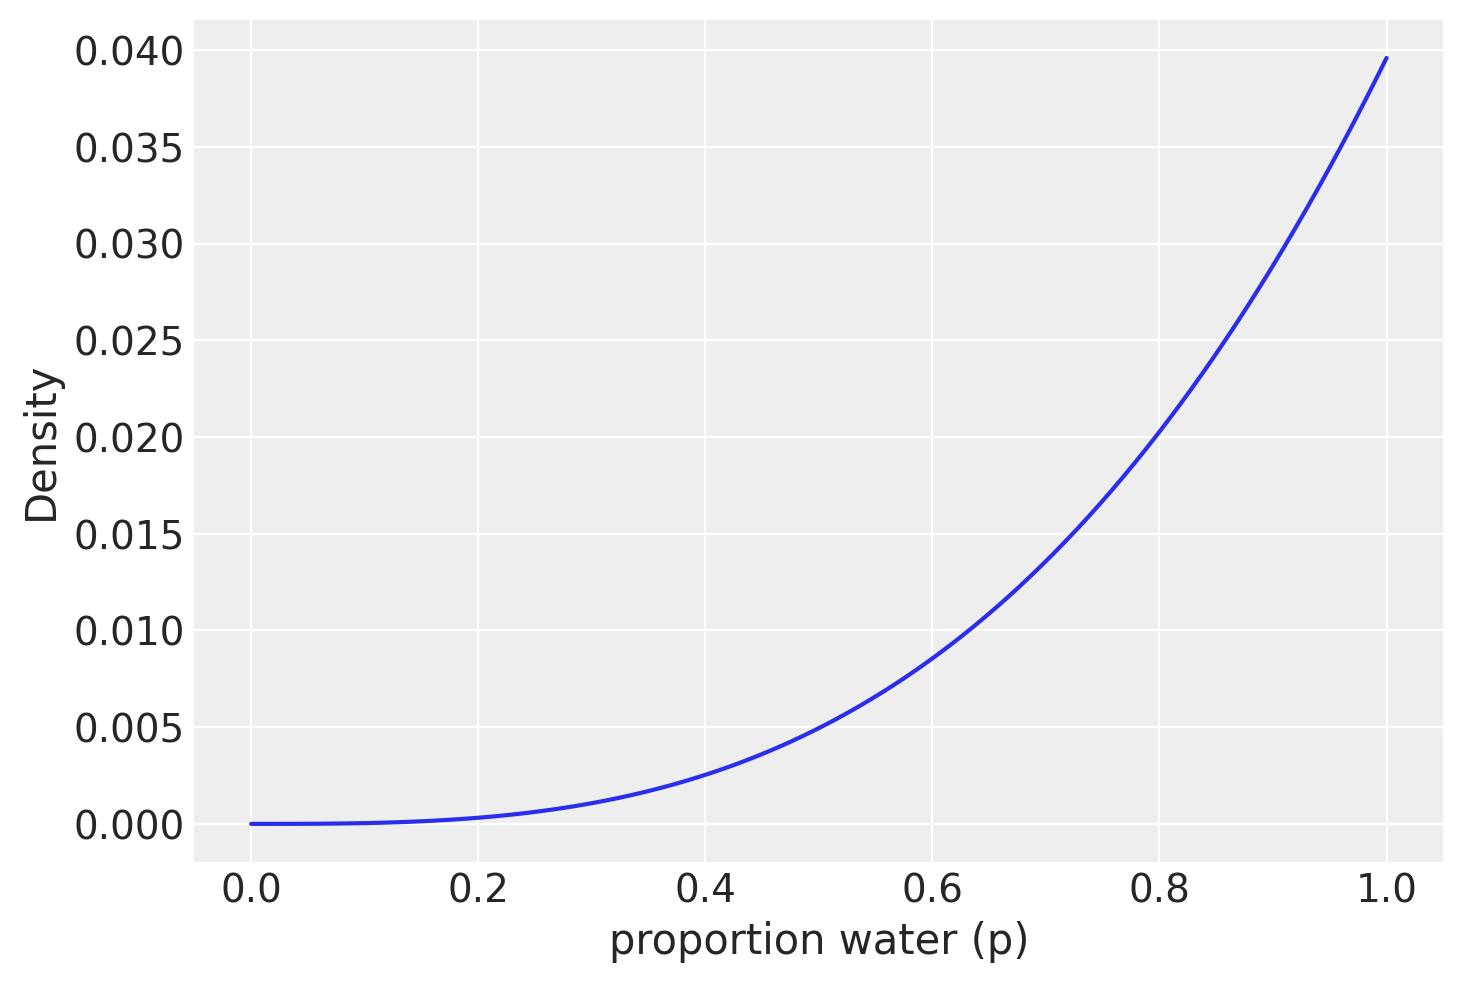

In [ ]:
p_grid_skewed, posterior_skewed = binom_post_grid_approx(uniform_prior, grid_points=100, success=3, tosses=3)
plt.plot(p_grid_skewed, posterior_skewed)
plt.xlabel("proportion water (p)")
plt.ylabel("Density")

#### Code 3.12

And if we sample the posterior and identified the 75th percentile, supposedly 94% of the posterior distribution lie below it. This is incorrect! The reason being is that if we look at the graph, most of the distribution is centered on the parameter value $p = 1$ which is why **percentile intervals** can sometimes be misleading.

In [ ]:
samples_skewed = np.random.choice(p_grid_skewed, p=posterior_skewed, size=int(1e4), replace=True)
np.percentile(samples_skewed, [25, 75])

array([0.70707071, 0.93939394])

#### Code 3.13

In contrast to percentile intervals, **highest posterior density intervals (HDPI)** which is designed to represent the parameter values that are most consistent with the data and returns an interval that's the most densest in the distribution, but also quite narrow. If we examine the results of the `az.hdi` function in Code 3.13, we'll that region containing 50% of the posterior probability is between $p = 0.84$ and $p = 1$, which is also narrower in width than the method containing percentile interval (0.16 < 0.23).

*(Note: This is probably why HDPI gets its own function in a Bayesian library instead of the percentile interval method where we have mannually input the 25th and 75th percentile using the* `np.percentile(samples_skewed, [25, 75])` *line)*

In [ ]:
az.hdi(samples_skewed, hdi_prob=0.5)

array([0.84848485, 1.        ])

To be fair however, **highest posterior density interval** has its weaknesses as well. For one, it's more taxing computationally and is also suffers from *simulation variance*, which is just another way of saying that it is sensitive to the amount of samples you draw from the posterior. It's also a bit harder to understand as compared to percentile intervals which many in the scientific or non-Bayesian audience already understand.

#### **Rethinking: What do compatibility intervals mean?** 

In non-Bayesian language, it's common to see statistical reports with a 95% "confidence interval" which is used to communicate that there is a 95% probability that the "true" parameter value lies within the interval. What these authors really mean is that if they repeated the study/analysis a large number of times, then 95% of the computed intervals would contain the "true" parameter value. Notice how I surrounded the word *true* in quotation marks because our models hardly every capture the true, objective parameter value in the *large* world that we're trying to draw inferences from. The only world where the true parameter value lies within a given interval 95% of the time is in the *small*, logical world that our golem lives and believes in. As inhabitants of the larger world, we're free to believe something else.

### 3.2.3. Point Estimates.

Remember that *the Bayesian parameter distribution equates to an entire posterior distribution as a function that maps each unique parameter value to a plausable posterior value.* Therefore, if someone asked you to report a single number from that distribution (i.e. a **point estimate**), not only is it unnecessary but also harmful as it discards useful information. 

However, if YOU DID have to report a single point that summarizes the posterior, the most common value that scientists report is the *maximum a posteriori*. The **maximum a posteriori (MAP)** is the parameter value with the highest posterior probability, which is computed in Code 3.14 using the skewed distribution. 

#### Code 3.14

In [ ]:
# Shows which parameter value is associated to the largest value in the posterior distribution.
p_grid_skewed[posterior_skewed == max(posterior_skewed)]

array([1.])

#### Code 3.15

We can also use the **mode** of the distribution to approximate the **maximum a posteriori**.

In [ ]:
stats.mode(samples_skewed)[0]

array([0.96969697])

In [ ]:
print(f" The parameter value, {round(float(stats.mode(samples_skewed)[0]), 3)} appeared most in the distribution \
at {float(stats.mode(samples_skewed)[1])} times and is therefore the mode.")

 The parameter value, 0.97 appeared most in the distribution at 406.0 times and is therefore the mode.


#### Code 3.16

In addition to the mode/maximum a posteriori, we can also consider the mean (0.803) or the median (0.848) of the distribution. But how do we choose?

In [ ]:
np.mean(samples_skewed), np.median(samples_skewed)

(0.8039616161616162, 0.8484848484848485)

#### Code 3.17 - Using Loss Functions to pick a Point Estimate.

One principled way to go about choosing a single point is by using the minimal point in a *loss function*. A **loss function** is a rule that tells us the associated cost with using any particular point estimate. *Different loss functions imply different point estimates*. If we think of most loss functions as an inward $\cup$, our goal is to get to the **global minimal value** which is the lowest part of the $\cup$ and is also often the true value in most cases.

$d$ = decision

$p$ = The correct answer. In this case, we'll use our priors as the correct answer.

In the graphs below, we've visualize what happens on each step of the loss function, $| d - p |$, we've decided on:

`loss_func = sum(posterior * abs(decision - p_grid_skewed))`.

The end result in Step 3 will be the ***weighted average loss*** *of the posterior loss distribution, where each loss is weighted by its corresponding posterior probability*. We'll first outline this process by setting our decision to $p = 0.5$ and then adding up all corresponding priors of the posterior probability distribution in order to get its weighted average loss:

In [ ]:
# Builing a plotting function for our convenience.
def line_plot(x_coords, y_coords, x_label=None, y_label=None, title=None, subplot=plt):
  subplot.plot(x_coords, y_coords)
  subplot.set_xlabel(x_label)
  subplot.set_ylabel(y_label)
  subplot.set_title(title)

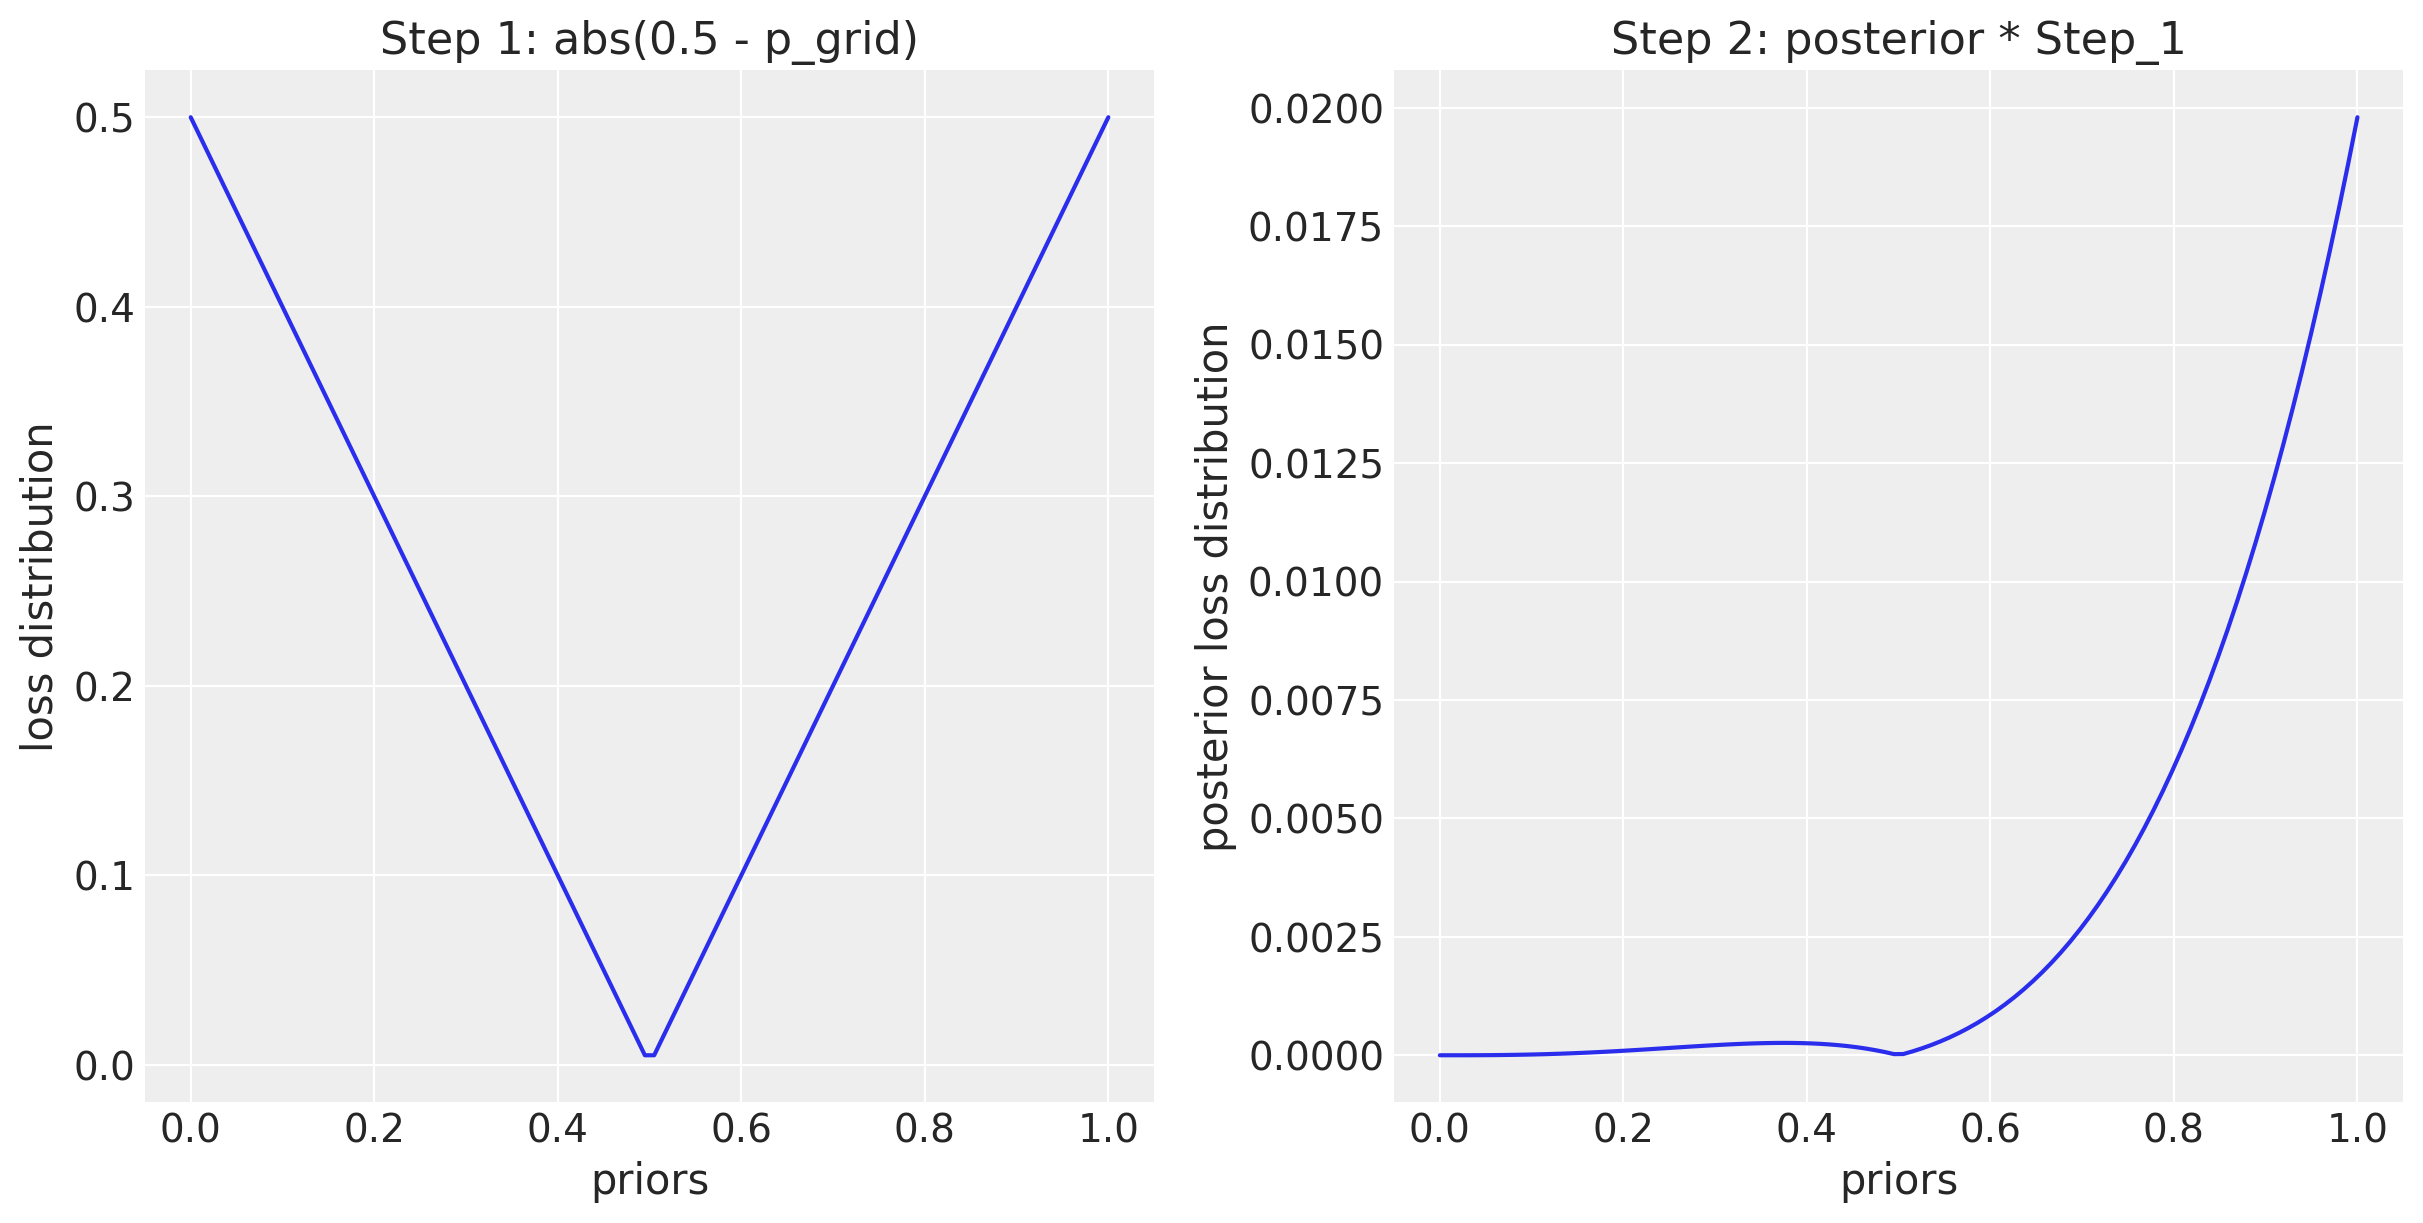

In [ ]:
# STEP 1: Visualizing every step of our loss function starting with the right hand side of this equation
decision = 0.5
loss_dist = abs(decision - p_grid_skewed)

#STEP 2: Then including what it would look like if we multiplied the posterior distribution
posterior_loss_dist = posterior_skewed * abs(0.5 - p_grid_skewed)

# Visualizing both steps side-by-side
_, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6))

line_plot(p_grid_skewed, 
          loss_dist, 
          x_label="priors", 
          y_label="loss distribution", 
          subplot=ax0,
          title="Step 1: abs(0.5 - p_grid)")

line_plot(p_grid_skewed, 
          posterior_loss_dist, 
          x_label="priors", 
          y_label="posterior loss distribution", 
          subplot=ax1,
          title="Step 2: posterior * Step_1")

In [ ]:
# STEP 3: Adding up all the values in the Posterior Loss Distribution
sum(posterior * abs(0.5 - p_grid_skewed))

0.16407647390830632

#### Code 3.18 

Here is what our posterior loss distribution looks like if we graphed <u>every possible decision</u> to determine which one would minimize our loss and determined the decision that minimizes our loss in Code 3.19.

In [ ]:
weighted_avg_losses = [sum(posterior_skewed * abs(each_decision - p_grid_skewed)) for each_decision in p_grid_skewed]

#### Code 3.19



In [ ]:
p_grid_skewed[weighted_avg_losses == min(weighted_avg_losses)]

array([0.84848485])

In [ ]:
min_decision_loss = p_grid_skewed[weighted_avg_losses.index(min(weighted_avg_losses))]
min_posterior_loss = weighted_avg_losses[weighted_avg_losses.index(min(weighted_avg_losses))]

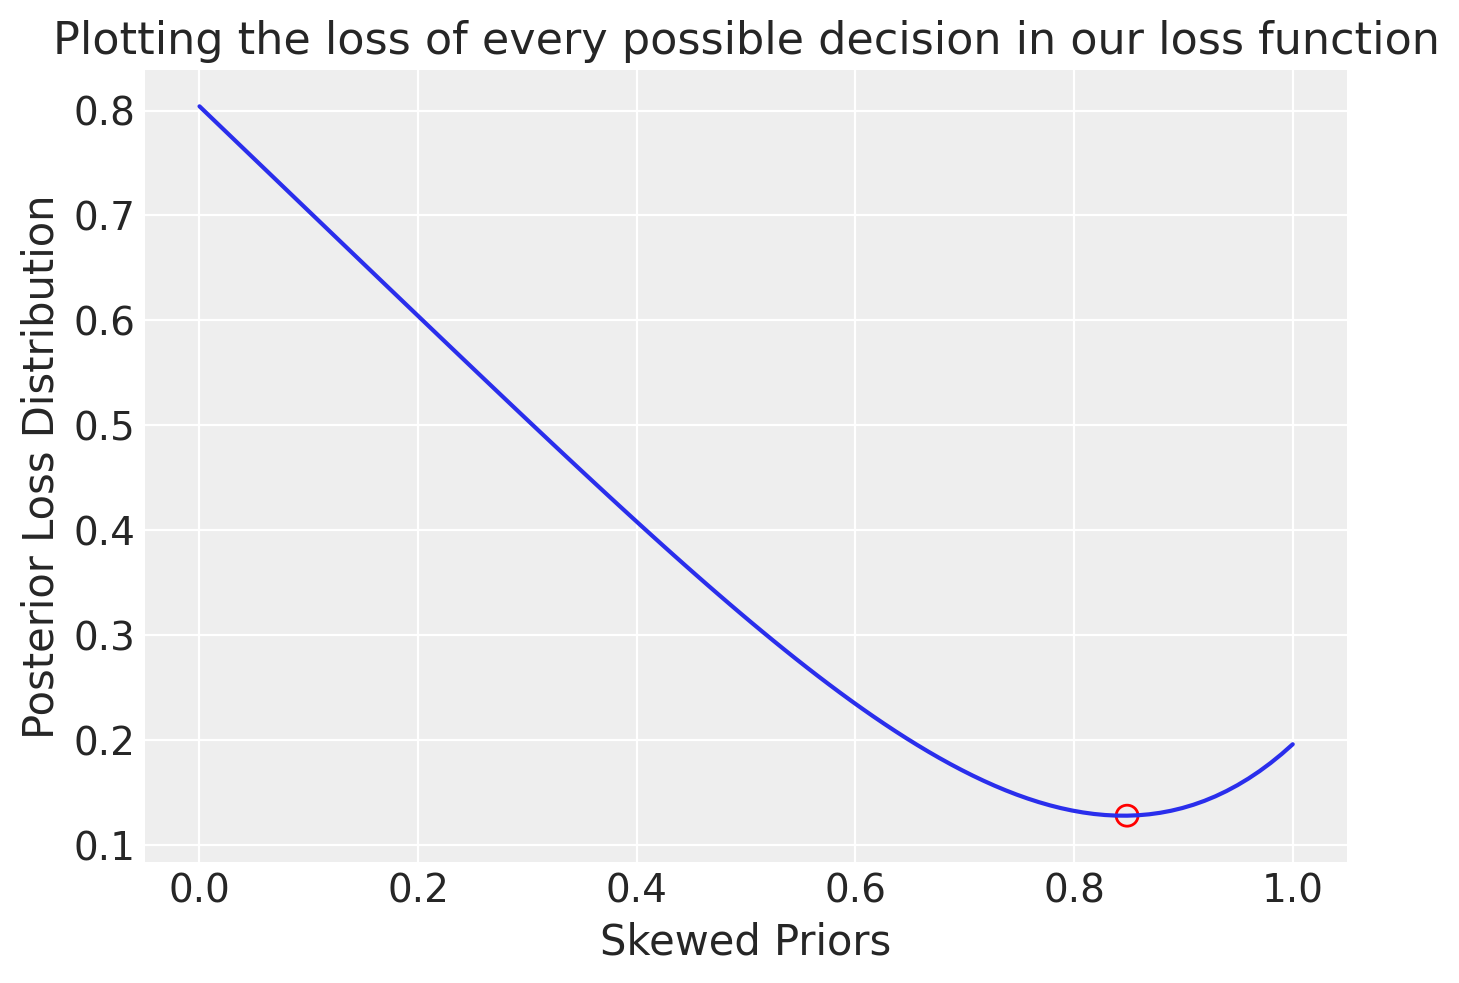

In [ ]:
_, (ax2) = plt.subplots(1, 1)
line_plot(p_grid_skewed, 
          weighted_avg_losses, 
          x_label="Skewed Priors", 
          y_label="Posterior Loss Distribution", 
          title="Plotting the loss of every possible decision in our loss function",
          subplot=ax2)

min_loss_pt = plt.Circle((min_decision_loss, min_posterior_loss), 
                        0.01, 
                        color='r', 
                        fill=False)

ax2.add_patch(min_loss_pt)

In [ ]:
print(f"The parameter value (i.e. decision) which leads to a minimal loss is {min_decision_loss} \n \
which equals to a posterior loss of {min_posterior_loss}")

The parameter value (i.e. decision) which leads to a minimal loss is 0.8484848484848485 
 which equals to a posterior loss of 0.1278931521108442


Surprisingly enough, the parameter value (0.8484) that leads to the smallest loss in our loss function is the SAME AS (or very close to) the **median** value in our sampled posterior distribution. But why is that?

The reason being is that the median parameter value splits the posterior density in half such that half of the mass is above it and half of the mass is below it. 

Just a reminder, the loss function we've chosen is the commonly used **absolute loss** function, $| d - p |$, which leads to the median as the point estimate. Another loss function that's just as common is the **quadratic loss** function, $(d - p)^2$, which results in the posterior mean as the point estimate. When the posterior distribution is symmetrical and normal-looking, we'll often find that the median and the mean converge to the same point which means we can relax any anxiety we might have in choosing a loss function. 

## *Section 3.3* - Sampling to simulate prediction

Another common use of sampling from the posterior distribution is to ease the **simulation** of our model's implied observation. Generating *implied observations* from a model is useful for 4 reasons:

1. *Model design*. Not only can we sample from the posterior, but we can also sample from the prior. Therefore if we sample from the priors, we'll be able to see what the model expects before the data arrives which will help us better understand the implications of the prior distribution.

2. *Model checking*. After a model us updated using data, it's worth simulating the implied observations, to check both whether the fit worked correctly and to investigate the model's behaviour. 

3. *Software validation*. In order to be sure that our model fitting software is working, its helpful to simulate observations under a known model, and then attempt to recover the values of the model's parameters using the simulated data.

4. *Research design*. If you can simulate observations from your hypothesis, then you can evaluate whether the research design can be effective. In a narrow sense, this means doing a **power analysis**, but with the possibilities being much broader.

5. ***Forecasting***. Estimates can be used to simulate new predictions, either for new cases or for future observations. These forecasts can be useful as an applied prediction, but also for criticizing and revising our model.

### 3.3.1. Dummy Data.

Before we get into sampling for the purpose of simulating prediction, let's first review the purpose of the *likelihood function* in Bayes' Theorem. A **likelihood function** tells us how plausible a given observation is. Given only the parameters, the likelihood function can also define a distribution of possible observations that we can sample from, to simulate observation. In this way, Bayesian models have the quality of being *generative*, meaning that they're capable of simulation. For now, we'll use the term, **dummy data**, to describe data that we've simulated as a stand-in for actual data. 

As a reminder, the equation to describe the likelihood function for a binomial distibution where there's only two outcomes (outcome $o_{1}$ & outcome $o_{2}$), such as heads/tails or water/land is the following: 

$$Pr(o_{1}, o_{2} \mid p) =  \frac{(o_{1} + o_{2})!}{o_{1}!o_{2}!} p^{o_{1}} (1 − p)^{o_{2}}$$

#### Code 3.20

Now, suppose we've only observed $N = 2$ tosses in our globe example. This means there can be only 3 possible values generated from this outcome: either we observe 0, 1, or 2 tosses landing on water. Let's use the code in 3.20 to generate the plausabilities of observing each of those outcomes, using a prior of $p = 0.7$ which is close to the true proportion of water-to-land on Earth.


In [ ]:
stats.binom.pmf(range(3), n=2, p=0.7)

array([0.09, 0.42, 0.49])

From the **likelihood function** function we've generated, we can interpret the results in the following way: 

- There's about a 9% chance that the globe lands on water 0 times out of 2 tosses;

- A 42% chance that the globe lands on water once out of the 2 tosses; 

- And a 49% chance that the globe lands on water in each of the 2 tosses.

In short, `scipy.stats.binom.pmf()` generates likelihoods, or proabilities, for a given conjecture of data (i.e. $P(E | H)$). 

#### Code 3.21

As opposed to generating probabilities for a given conjecture of data, instead we can also simulate observations using given probabilities by using the `binom.rvs` function in the `scipy.stats` package. Below is an example of how to use the function:

In [ ]:
stats.binom.rvs(n=2, p=0.7, size=1)

array([1])

Note that `rvs` stands for **random variates**. The key parameters for the `scipy.stats.binom.rvs()` function are as follows:

- `n`: The number of possible outcomes. For example, if our argument for this parameter is $n=2$, this is equivalent to the numpy function: `np.arange(2) = [0, 1, 2]`
- `p`: The probability of the generating the distribution. So for example, if we're generating the observations of a coin flip, we can expect $p$ to obe $0.5$ meaning there's a 50/50 chance that the coin will land on either heads or tails. In our globe-tossing experiment, $p=0.7$ meaning that there's a 70/30 chance that globe will land on water, as opposed to land. 
- `size`: The number of observations we want to generate.

#### Code 3.22

In [ ]:
# Now let's simulate 10 observations using the random variates function
stats.binom.rvs(n=2, p=0.7, size=10)

array([2, 2, 1, 1, 1, 2, 2, 0, 2, 1])

#### Code 3.23

Now let's generate 100,000 dummy observations and verify the proportion of each value (i.e. 0, 1, or 2) appearing based on the likelihoods we generated in Code 3.20:

In [ ]:
dummy_w = stats.binom.rvs(n=2, p=0.7, size=int(1e5))
[(dummy_w == i).mean() for i in range(3)]

[0.09088, 0.42142, 0.4877]

*Looks* as though our simulated proportions match the likelihoods we calculated in Code 3.20 of each value appearing! The process of generating likelihoods and then simulating those observations and then comparing the proportions of each value appearing with their likelihoods is an example of **model checking**!

#### Code 3.24

Now instead of simulating the results from only 2 tosses of the globe, let's use the same `rvs` function to simulate 9 tosses similar to what we did with the in-person experiment. We'll repeat this experiment 100,000 times and use the true proportion of water-to-land as our $p$ argument.

***Figure 3.5*** illustrates how the results - 6 & 7 - appeared the most frequently in our 100,000 trialed experiment. 

Text(0, 0.5, 'Frequency')

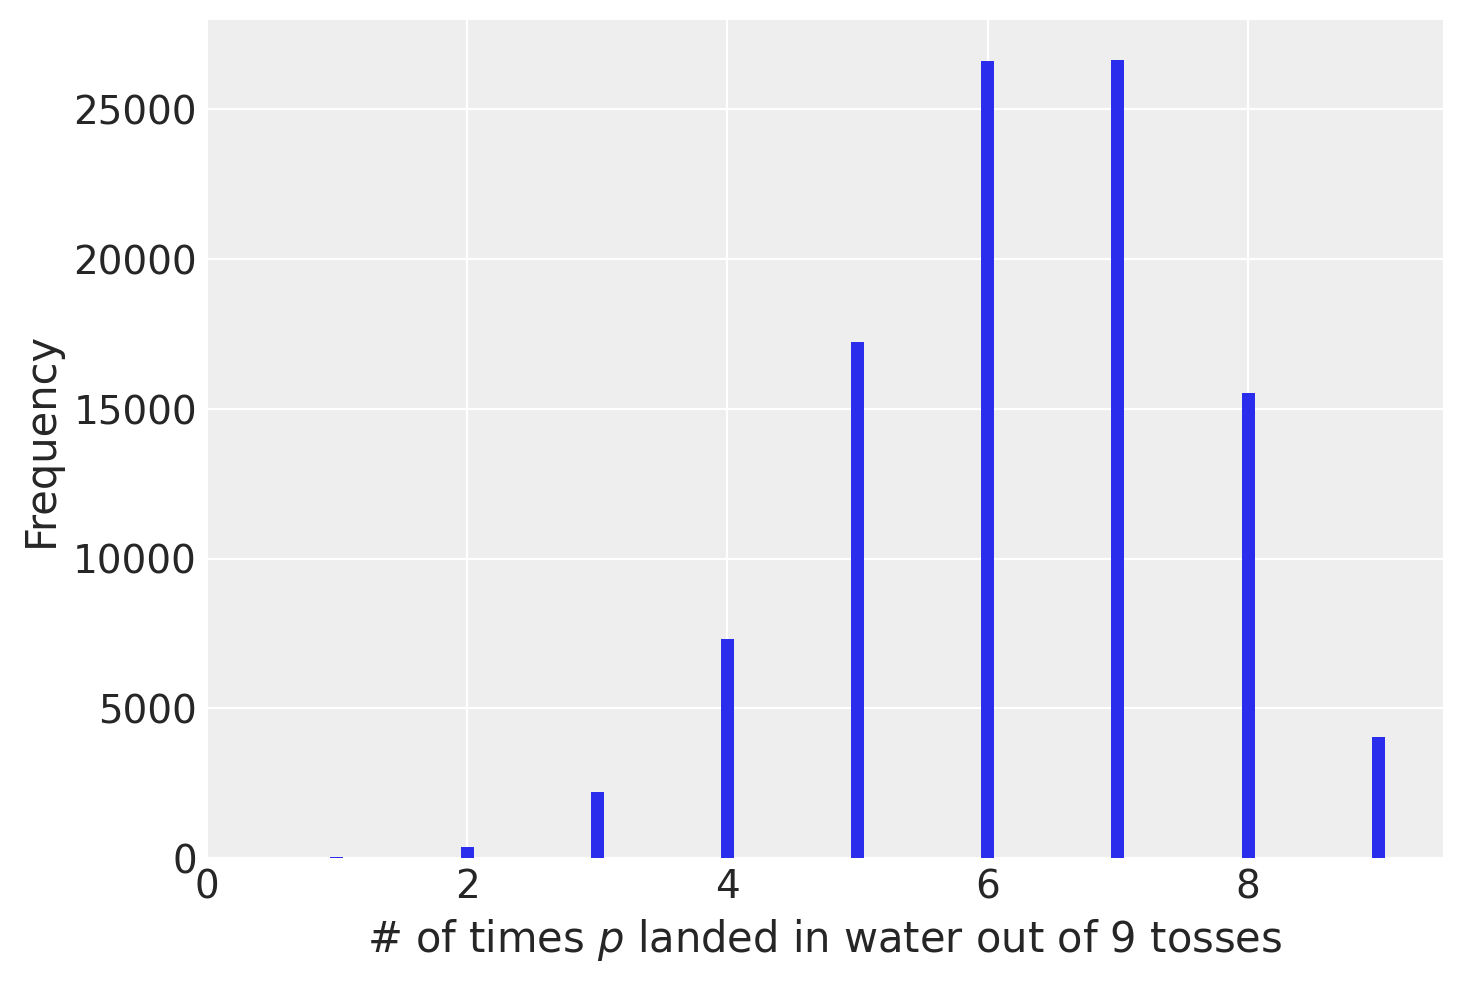

In [ ]:
dummy_w = stats.binom.rvs(n=9, p=0.7, size=int(1e5))
bar_width = 0.1
plt.hist(dummy_w, bins=np.arange(0, 11) - bar_width / 2, width=bar_width)
plt.xlim(0, 9.5)
plt.xlabel("# of times $p$ landed in water out of 9 tosses")
plt.ylabel("Frequency")

### 3.3.2. Model Checking.

**Model Checking** means to:

A) Ensure that the model fitting stage works correctly, and

B) Evaluate the adequacy of a model for some purpose. 


Since Bayesian models are always **generative** by being able to simulate observations as well as estimate parameters from observations, once you condition a model on data, you can simulate to examine the model's empirical expectations.

#### 3.3.2.1. *Did the software work?*

In the simplest case, we can check whether the model worked by checking for correspondence between implied predictions and the data used to fit the model. Let's call this **retrodictions** because we're trying to get our golem to correctly *predict past data*. In other words, when we're generating **retrodictions** we're asking the model to reproduc the data used to educate it, which is what we did in Code 3.24.

There's no way to be absolutely certain that the software works correcltly though even if our model reproduced the results we were expecting to see. There may have still been some subtle mistakes and when we move on to multi-level models, we'll start to expect a certain pattern of disconnect between retrodictions and observations. While this method is imperfect, we will be able to catch a lot of silly mistakes this way. 

#### 3.3.2.2. *Is the model adequate?*

After validating whether the data processing software worked as expected, its also useful to look into aspects of the data that were not well-described by the model's expectations. This process is not meant to check whether the model's assumptions are "true," because all models are false. Rather, the goal is to assess exactly how the model fails to describe the data in order for us to better comprehend our model's results, make revisions, and improve its predictive capabilities. 

When we sample from the ENTIRE *posterior distribution*, rather than by picking a *point estimate* and drawing conlusions or running calculations from it, we'll be able to generate better results. The reason why its better to sample from the entire distribution rather than a point estimate is because there is a lot of information about **uncertainty** in the posterior distribution, which we'll lose from point estimates. The *uncertainty* that comes from the implied predictions in a model come about in 2 ways:

1. **Observation uncertainty**. Just because you might know what the prior may be, for example in the context of a coin toss ($p = 0.5$) or a globe toss ($p = 0.71$), there is still uncertainty with what the next observation/toss will be. 
2. **Uncertainty with the prior**. Because there's an inherent uncertainty with the prior, the resulting posterior will inherit (or in other words, **propogate** - *carry it forward*) that uncertainty as well in addition to everything else that's dependent on the prior. This uncertainty with the prior will interact with the sampling variation when we're trying to assess what the model is telling us about the outcomes. Figure 3.6 in the textbook does an excellent job visualizing how we can capture/propogate a model's uncertainty by averaging over the posterior density for $p$, while computing the predictions:

<ol>
  <ol type="a">
    <li>For each possible value of $p$ there is an implied distribution of outcomes;</li>
    <li>So if we compute the distribution of outcomes for each possible value of $p$, we can then average all of the outcomes together; </li>
    <li> And lastly, generate a <b>posterior predictive distribution</b> using the <b>weighted average frequency</b> of each possible paramater value of $p$. </u>
  </ol>
</ol>




#### Code 3.25

In [ ]:
# dummy_325 = stats.binom.rvs(n=9, p=0.6, size=int(1e4))

**[ChatGPT](https://chat.openai.com/chat)**

<img src="https://openai.com/content/images/size/w1400/2022/11/ChatGPT.jpg">

#### Code 3.26

To propogate this parameter uncertainty with these predictions, we can replace the `p` value with samples from the posterior (i.e. p_grid samples with posterior probabilities):

In [ ]:
dummy_globe = stats.binom.rvs(n=9, p=samples)

Text(0, 0.5, 'Frequency')

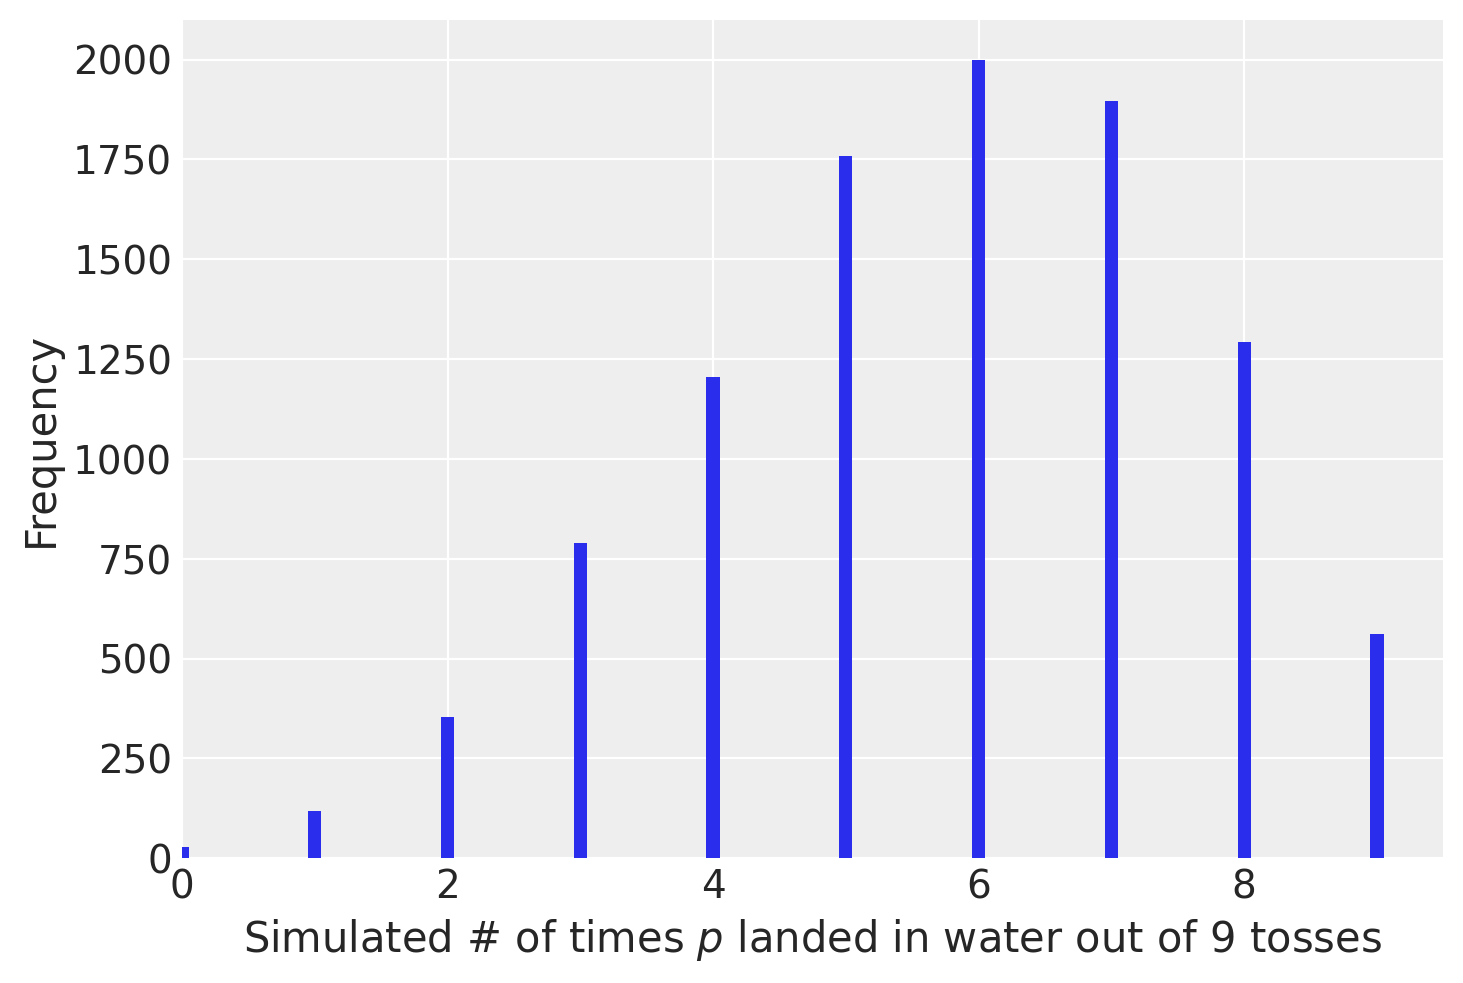

In [ ]:
bar_width = 0.1
plt.hist(dummy_globe, bins=np.arange(0, 11) - bar_width / 2, width=bar_width)
plt.xlim(0, 9.5)
plt.xlabel("Simulated # of times $p$ landed in water out of 9 tosses")
plt.ylabel("Frequency")

As we expect, the frequency of simulated observations we generated from the propabilities sampled from the globe toss' posterior distribution appear in proportion to their posterior probabilities. The simulated model predictions are quite consistent with the observed data in this case - the actual count of 6 lies right in the middle of the simulated distribution. 

## Exercises

#### Code 3.27

In [ ]:
p_grid, posterior = binom_post_grid_approx(uniform_prior, grid_points=100, success=6, tosses=9)
np.random.seed(100)
samples = np.random.choice(p_grid, p=posterior, size=int(1e4), replace=True)

#### Code 3.28

In [ ]:
# fmt: off
birth1 = np.array([1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0,
                   1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1])
birth2 = np.array([0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0,
                   1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                   1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1,
                   0, 0, 0, 1, 1, 1, 0, 0, 0, 0])
# fmt: on

#### Code 3.30

In [ ]:
sum(birth1) + sum(birth2)

111

In [ ]:
%watermark -n -u -v -iv -w

UsageError: Line magic function `%watermark` not found.
